### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


### Example Usage

Download an image from the PyTorch homepage

In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x788b0a4f2800>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Downloading: "https://github.com/isl-org/MiDa

Move model to GPU if available

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

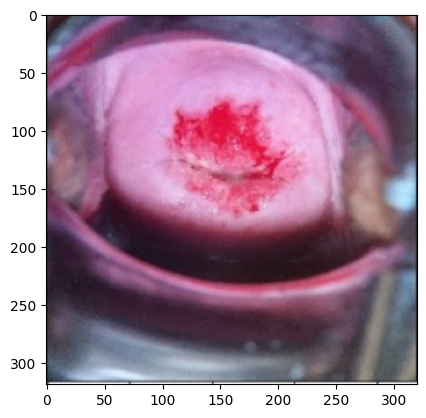

In [ ]:
img = cv2.imread("/content/cer.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
plt.imshow(img)

Predict and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

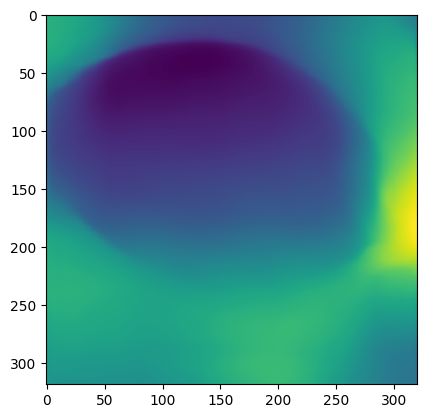

In [ ]:
plt.imshow(output)
# plt.show()

In [ ]:
output.shape()

(319, 320)

In [ ]:
height, width = output.shape

In [ ]:
x_coords = np.repeat(np.arange(width), height)
y_coords = np.tile(np.arange(height), width)

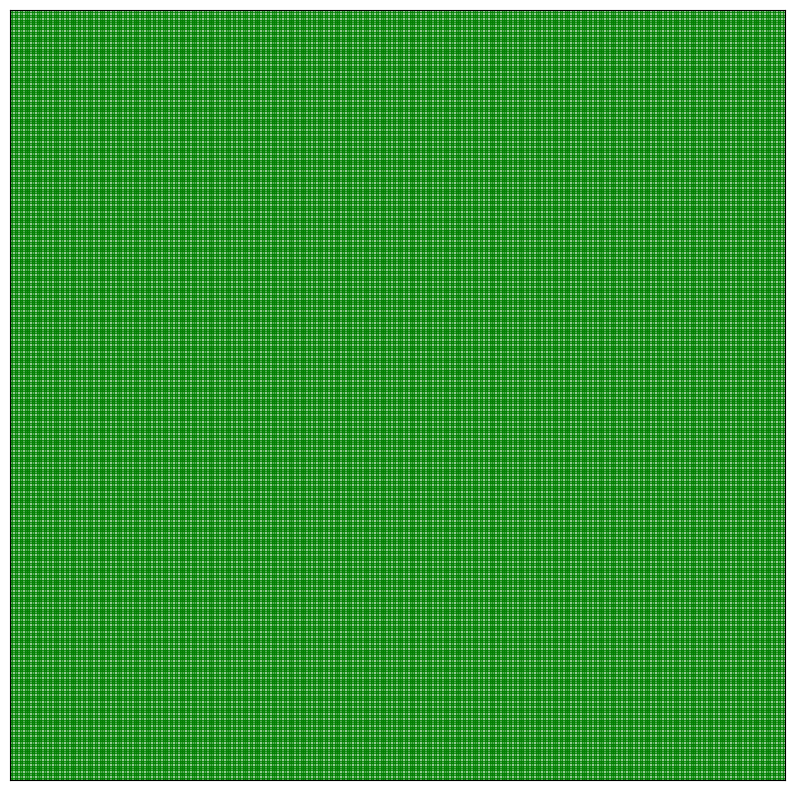

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, color='green', s=1)  # s controls the size of the dots

# Customize the plot
plt.gca().set_facecolor('white')  # Set the face color of the plot to white
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlim(0, width)  # Set x-axis limits
plt.ylim(0, height)  # Set y-axis limits

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [ ]:
x = np.arange(output.shape[1])
y = np.arange(output.shape[0])
X, Y = np.meshgrid(x, y)

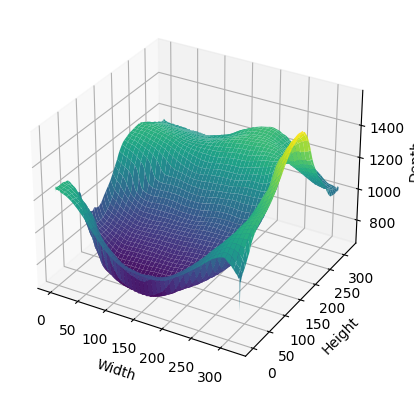

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, output, cmap='viridis')

# Set labels
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_zlabel('Depth')

plt.show()

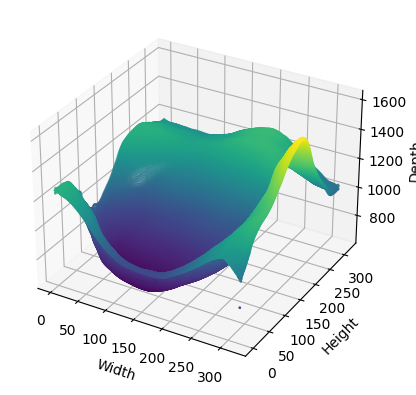

In [ ]:
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = output.flatten()

# Plot 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_flat, Y_flat, Z_flat, c=Z_flat, cmap='viridis', s=1)

# Set labels
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_zlabel('Depth')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection="3d")

STEP = 3

for x in range(0, img.shape[0], STEP):
    for y in range(0, img.shape[1], STEP):
        ax.scatter([x], [y], [output[x, y]], c=img[x, y] / 255, s=3)

ax.view_init(45, 135)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')

plt.show()

<ipython-input-13-125aacf7b115>:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([x], [y], [output[x, y]], c=img[x, y] / 255, s=3)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7cc37f4101f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
depth_8bit = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, thres = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#print(thresholded)
thres.shape

(319, 320)

In [ ]:
mask = thres > 0

In [ ]:
print(mask)

[[ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ...  True  True  True]]


In [ ]:
output.shape

(319, 320)

In [ ]:
import numpy as np

In [ ]:
mask = mask.astype(np.bool_)
invalid_value = 0
# Apply the mask to the depth map using element-wise multiplication
masked_depth = np.where(mask, output, invalid_value)



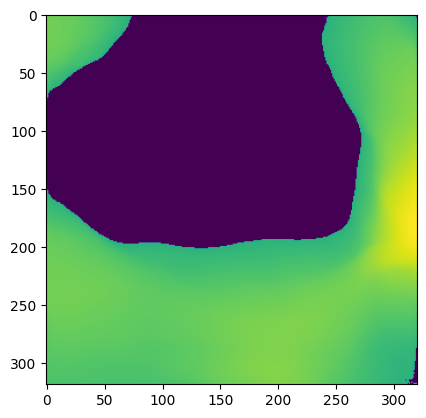

In [ ]:
plt.imshow(masked_depth)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
depth_values = output.flatten().reshape(-1, 1)

# Perform K-Means clustering to separate the depth values into k clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(depth_values)

# Get the cluster centers
cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

# The threshold is set at the midpoint between the two clusters
threshold = (cluster_centers[0] + cluster_centers[1]) / 2

# Create a binary mask based on the threshold
thresholded = (output >= threshold) * 255

thresholded =  thresholded.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


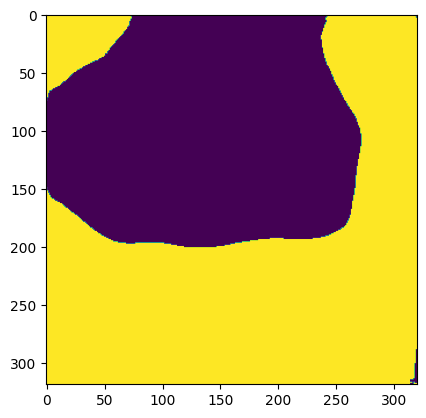

In [ ]:
plt.imshow(thresholded)

array([[255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
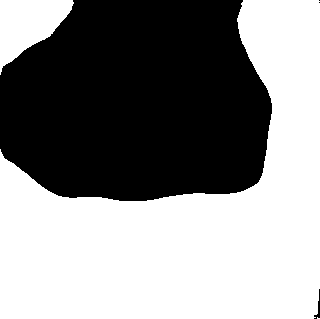

In [ ]:

thresholded

In [ ]:
masked_depth2 = np.where(thresholded, output, invalid_value)

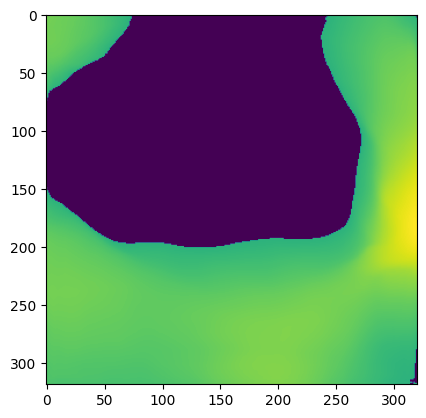

In [ ]:
plt.imshow(masked_depth2)

In [ ]:
mask2 = output >= threshold

In [ ]:
masked_depth3 = np.where(mask2, output, invalid_value)

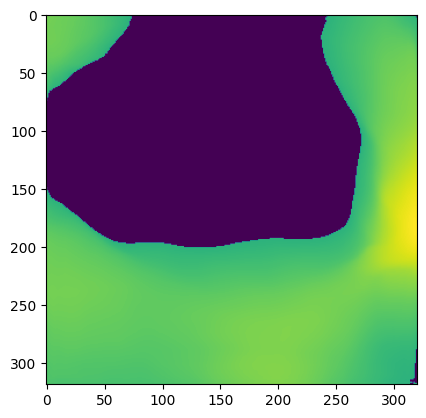

In [ ]:
plt.imshow(masked_depth3)

In [ ]:
masked_depth3

array([[1259.06  , 1246.3071, 1254.8738, ..., 1046.1586, 1056.2809,
           0.    ],
       [1235.8416, 1256.9465, 1258.7096, ..., 1053.6117, 1034.2058,
        1036.8022],
       [1267.478 , 1260.0809, 1255.8802, ..., 1055.577 , 1047.818 ,
           0.    ],
       ...,
       [1151.6323, 1153.3936, 1148.52  , ...,    0.    ,    0.    ,
           0.    ],
       [1155.9938, 1158.5208, 1153.8756, ..., 1025.5377,    0.    ,
           0.    ],
       [1158.8917, 1155.1061, 1151.3615, ..., 1032.6075, 1032.5581,
        1027.104 ]], dtype=float32)

In [ ]:
[thresholded]*3

[array([[255, 255, 255, ..., 255, 255,   0],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ..., 255,   0,   0],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 array([[255, 255, 255, ..., 255, 255,   0],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ..., 255,   0,   0],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 array([[255, 255, 255, ..., 255, 255,   0],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ..., 255,   0,   0],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [ ]:
mask_rgb = np.stack([thresholded]*3 , axis=-1)
rgb_image = img.astype(np.uint8)
rgb_image = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb = img * mask_rgb

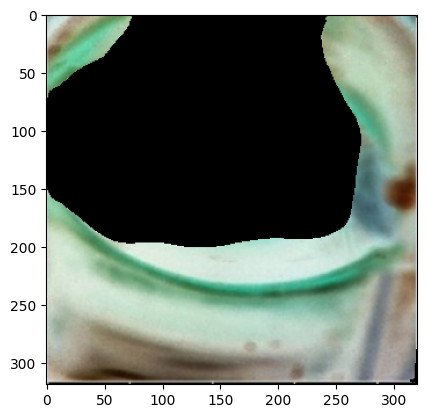

In [ ]:
plt.imshow(masked_rgb)

In [ ]:
mask2 = (thresholded == 255)

In [ ]:
mask_rgb3 = np.stack([mask2]*3 , axis=-1)
rgb_image3 = img.astype(np.uint8)
rgb_image3 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)

masked_rgb3 = img * mask_rgb3

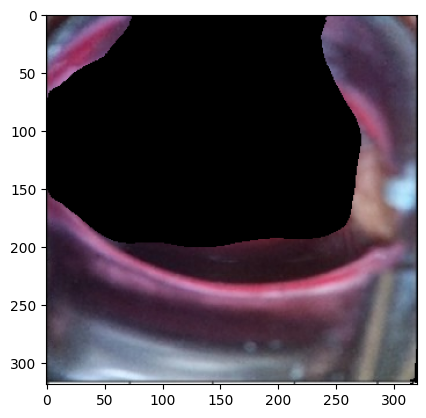

In [ ]:
plt.imshow(masked_rgb3)

In [ ]:
rev_mask = np.logical_not(mask)

In [ ]:
mask_rgb3 = np.stack([rev_mask]*3 , axis=-1)
rgb_image3 = img.astype(np.uint8)
rgb_image3 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)

final = img * mask_rgb3

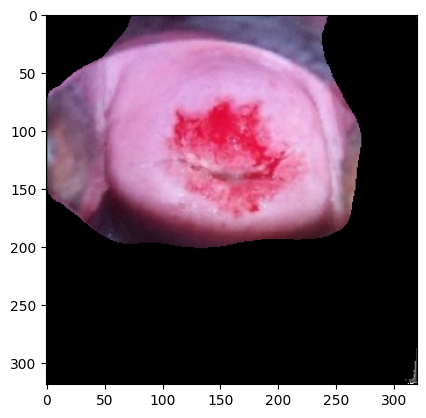

In [ ]:
plt.imshow(final)

In [ ]:
mask_rgb2 = np.stack([mask]*3 , axis=-1)
#rgb_image2 = img.astype(np.uint8)
#rgb_image2 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb2 = img * mask_rgb2

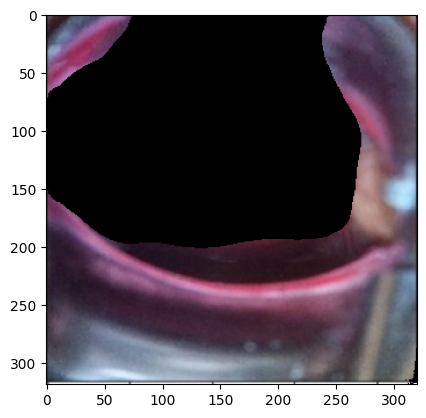

In [ ]:
 plt.imshow(masked_rgb2)

In [ ]:
depth_8bit = cv2.normalize(masked_depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, thres2 = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#print(thresholded)
thres2.shape

(319, 320)

In [ ]:
mask4 = thres2 > 0

In [ ]:
mask_rgb4 = np.stack([mask4]*3 , axis=-1)
rgb_image4 = img.astype(np.uint8)
rgb_image4 = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb4 = img * mask_rgb4

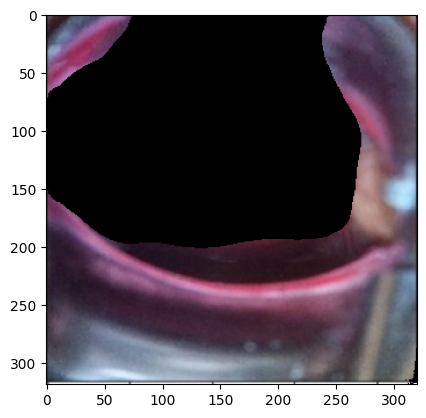

In [ ]:
plt.imshow(masked_rgb4)

In [ ]:
depth_values = masked_depth3.flatten().reshape(-1, 1)

# Perform K-Means clustering to separate the depth values into k clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(depth_values)

# Get the cluster centers
cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

# The threshold is set at the midpoint between the two clusters
threshold = (cluster_centers[0] + 4*cluster_centers[1]) / 5

# Create a binary mask based on the threshold
thresholded2 = (output >= threshold) * 1

thresholded =  thresholded.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
mask_rgb4 = np.stack([thresholded2]*3 , axis=-1)
rgb_image4 = img.astype(np.uint8)
rgb_image = cv2.normalize(rgb_image, None, 0, 255, cv2.NORM_MINMAX)


# Apply the mask to the RGB image using element-wise multiplication
masked_rgb4 = img * mask_rgb4

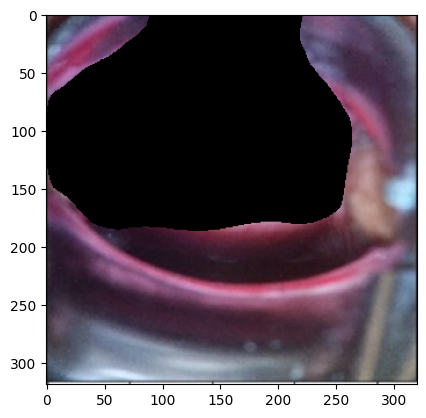

In [ ]:
plt.imshow(masked_rgb4)

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: unexpected character after line continuation character (<ipython-input-71-23ca58b53b1e>, line 2)

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}

SyntaxError: unexpected character after line continuation character (<ipython-input-72-1a8ff6aaf8f8>, line 2)